In [95]:
from graph_tool.all import *
import numpy as np
import pandas as pd
import matplotlib.cm as cm

In [2]:
g = Graph()
v1 = g.add_vertex()
v2 = g.add_vertex()
e = g.add_edge(v1, v2)

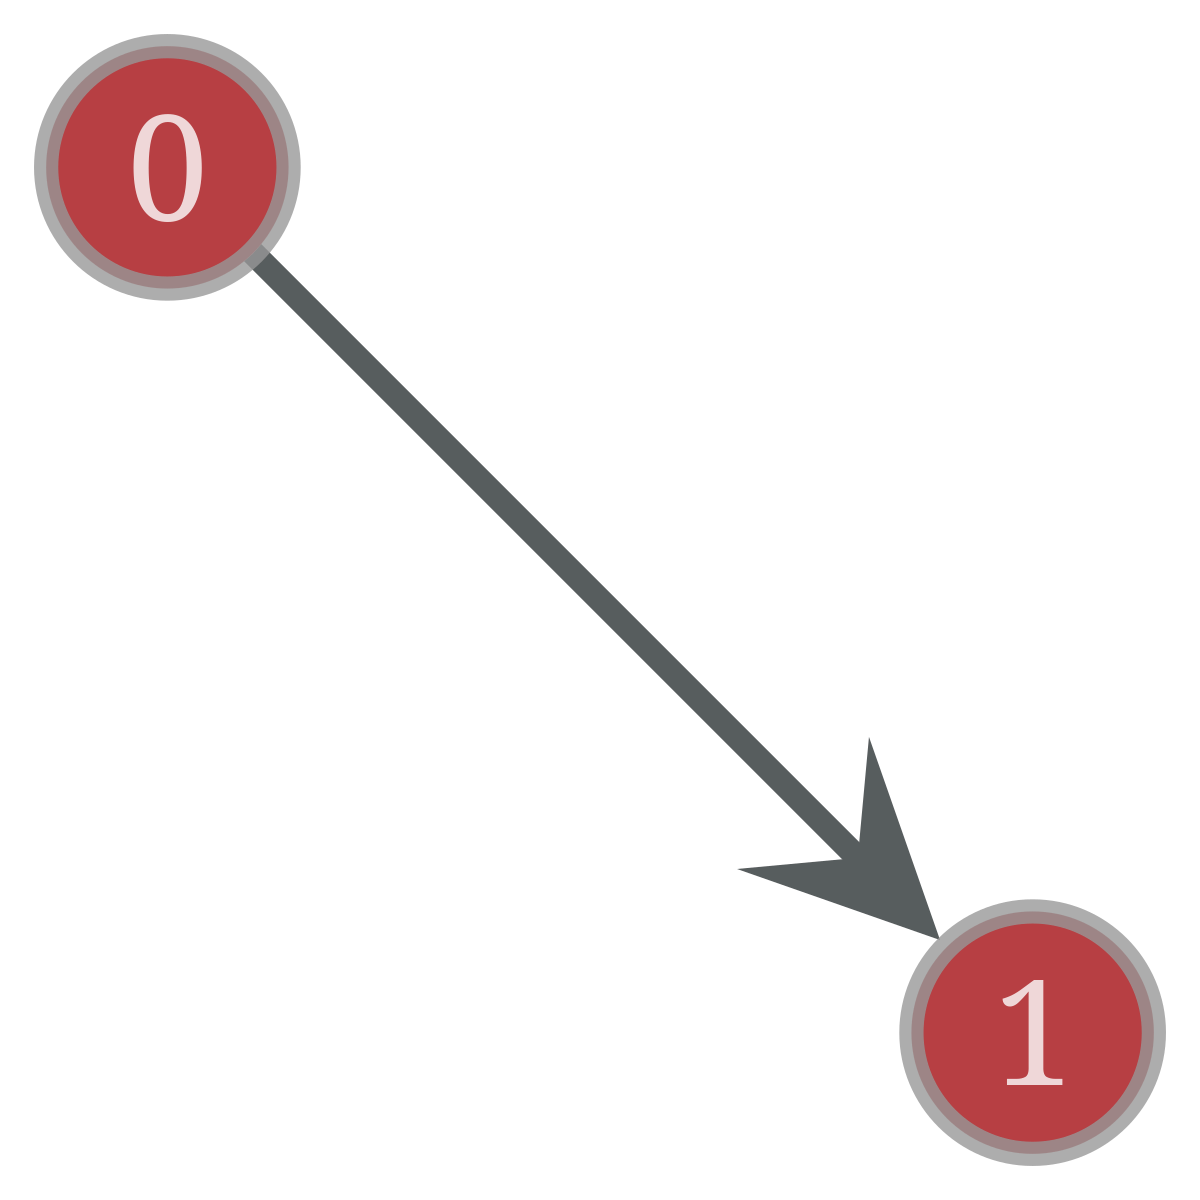

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8bb107ddb0, at 0x7f8bb107e770>

In [3]:
graph_draw(g, vertex_text=g.vertex_index)

In [7]:
g = collection.data["celegansneural"]
print(g)

<Graph object, directed, with 297 vertices and 2359 edges, 2 internal vertex properties, 1 internal edge property, 2 internal graph properties, at 0x7f8baf947220>


In [10]:
state = minimize_nested_blockmodel_dl(g)
S1 = state.entropy()
mcmc_anneal(state, beta_range=(1, 10), niter=1000, mcmc_equilibrate_args=dict(force_niter=10))
state.entropy() - S1

-80.7540728947206

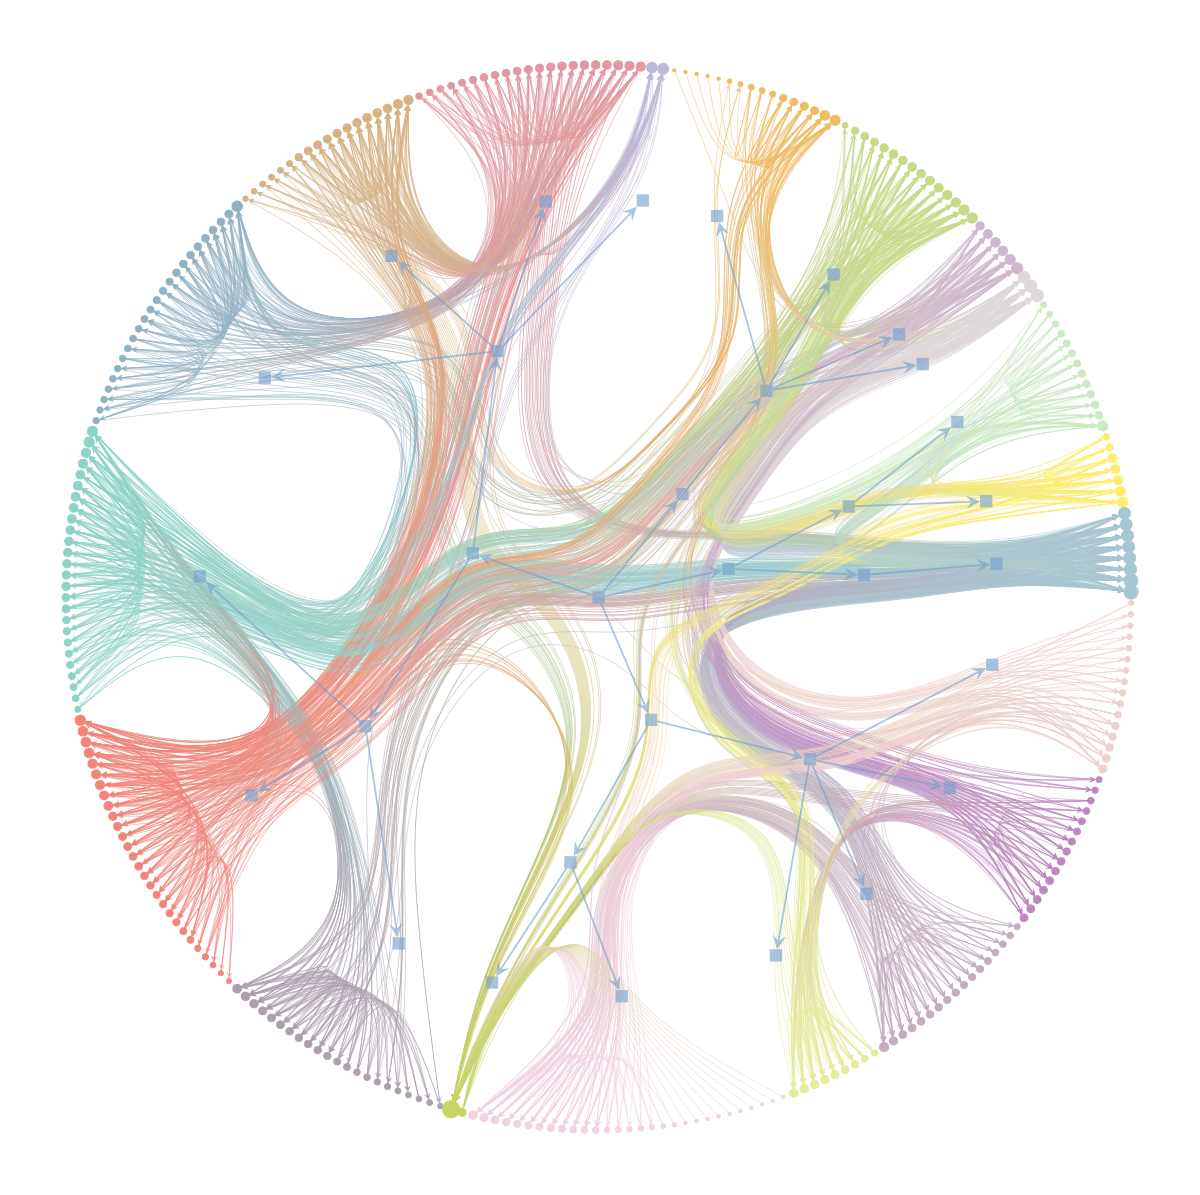

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8baf947220, at 0x7f8baf80c400>,
 <Graph object, directed, with 329 vertices and 328 edges, at 0x7f8c2ef62ad0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8c2ef62ad0, at 0x7f8baf99c8e0>)

In [11]:
state.draw()

In [3]:
g = load_graph("level7.gt")
g

<Graph object, undirected, with 770 vertices and 4747 edges, 2 internal vertex properties, 1 internal edge property, at 0x7ff96305d180>

In [22]:
abun = pd.read_csv("level-7.csv", index_col="index")
otus = np.array(abun.iloc[:, 0:685].columns)
samples = np.array(abun.index)

In [23]:
g = Graph(directed=False)
g.add_vertex(len(samples) + len(otus))

<generator object Graph.add_vertex.<locals>.<genexpr> at 0x7f6daf625e00>

In [24]:
name = g.vp.name = g.new_vertex_property("string", np.append(samples, otus))
part = g.vp.part = g.new_vertex_property("int", np.append(np.ones(len(samples)), np.zeros(len(otus))))
counts = g.ep.counts = g.new_edge_property("double")

In [25]:
for si in range(len(samples)):
    # v = g.add_vertex()
    # name[v] = s
    for ti in range(len(samples), len(samples) + len(otus)):
        # w = g.add_vertex()
        c = int(abun.loc[name[si], name[ti]])
        if c > 0:
            e = g.add_edge(si, ti)
            counts[e] = np.log(c) + 1

In [30]:
g.save("level7.gt")

## Fit the hSBM

In [151]:
state_args = {"clabel": part, "pclabel": part, "eweight": counts, "deg_corr": True}
state_tmp = minimize_nested_blockmodel_dl(g, state_args=state_args)

In [152]:
S1 = state_tmp.entropy()

for i in range(100): # this should be sufficiently large
    state_tmp.multiflip_mcmc_sweep(beta=np.inf, niter=10)

S2 = state_tmp.entropy()
print("Improvement:", S2 - S1)

Improvement: -755.1559991054892


In [153]:
L = 0
for s in state_tmp.levels:
    L += 1
    if s.get_nonempty_B() == 2:
        break
state = state_tmp.copy(bs=state_tmp.get_bs()[:L] + [np.zeros(1)])

In [154]:

state.draw(
    layout="bipartite", output="level7-modules.pdf", subsample_edges=1000, hshortcuts=1, 
    # edge_pen_width=prop_to_size(g.ep.counts, ma=4, power=1.2, log=False), 
    edge_pen_width=1.5,
    vertex_size=1.6,
    vertex_fill_color=part,
    vertex_color=part,
    edge_color=prop_to_size(counts, ma=10, power=1),
    ecmap=(cm.inferno, .4), edge_gradient=[], eorder=counts
)

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f6daeddf520, at 0x7f6da0b466b0>,
 <Graph object, directed, with 961 vertices and 960 edges, at 0x7f6da0b46470>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f6da0b46470, at 0x7f6da0b44d00>)

In [199]:
# levels = state.project_partition()
from collections import defaultdict
# group_id = nested_contiguous_map(state.get_bs())[1]
group_id = state.get_levels()[4].get_blocks().a
group_names = defaultdict(lambda: list())
for v, i in enumerate(group_id):
    group_names[i].append(name[v])

In [253]:
membership = dict()
for lvl in range(4):
   state_proj = state.project_level(lvl)
   mem = defaultdict(lambda: list())
   for v, i in enumerate(state_proj.get_blocks().a):
      mem[i].append(name[v])
   membership[lvl] = list(mem.values())

In [254]:
membership

{0: [['HH01_01', 'HH01_03', 'HH01_09'],
  ['HH01_02', 'HH01_08', 'HH02_16'],
  ['HH01_04'],
  ['HH01_05', 'HH01_24', 'HH02_22'],
  ['HH01_06', 'HH01_12'],
  ['HH01_07', 'HH01_20', 'HH02_12', 'HH02_20'],
  ['HH01_10', 'SS08_01'],
  ['HH01_11'],
  ['HH01_13', 'HH02_19'],
  ['HH01_14', 'HH02_23'],
  ['HH01_15', 'SS15_03', 'SS15_05', 'SS15_07'],
  ['HH01_17', 'HH02_01'],
  ['HH01_18', 'HH02_03'],
  ['HH01_19', 'HH01_21'],
  ['HH01_22'],
  ['HH01_23'],
  ['HH02_02'],
  ['HH02_04', 'HH02_24'],
  ['HH02_05'],
  ['HH02_06'],
  ['HH02_07'],
  ['HH02_08'],
  ['HH02_09', 'HH02_10'],
  ['HH02_11'],
  ['HH02_13', 'HH02_21'],
  ['HH02_14'],
  ['HH02_15'],
  ['HH02_17'],
  ['HH02_18'],
  ['SH12_01'],
  ['SH12_02', 'SH12_03'],
  ['SH12_04', 'SH15_07'],
  ['SH13_05', 'SS15_01', 'SS15_06'],
  ['SH13_06', 'SH15_09'],
  ['SH13_07', 'SH15_06'],
  ['SH13_08', 'SH13_09', 'SH13_10'],
  ['SH15_01', 'SS14_09', 'SS14_10'],
  ['SH15_02', 'SH15_05'],
  ['SH15_03'],
  ['SH15_04'],
  ['SH15_08'],
  ['SH15_10'],
  ['

In [256]:
import pickle
with open("module-members.pickle", "wb") as f:
    pickle.dump(membership, f)